#  AM11 - Machine Learning for Big Data: Final Assignment
by: Richard Jungner (3894584)

## 1. Library import

In [130]:
# General
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random

# Pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import auc, roc_curve, precision_recall_curve

In [131]:
# Seeting random seed
random_seed = 99

tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

## 2. Data pre-processing
In this section I will preprocess the data.

### 2.1 Reading data

In [132]:
# reading data
path = os.getcwd()

X = pd.read_pickle(path+"/design_matrix.pkl")
y = pd.read_pickle(path+"/target.pkl").squeeze()

# converting column names to strings
X.columns = X.columns.astype("str")

In [133]:
# very brief data inspection
print("Number of features:", len(X.columns))
print("Target variable values:", y.unique())

Number of features: 558
Target variable values: [1. 0.]


We are dealing with a binary classification problem (target variable can be 1 or 0) and we have 558 features.

### 2.2 Train, validation, test split

In [134]:
##### Train, validation, test split #####

# data split decisions according to assignment instructions
days_for_test = 65
share_of_train = 0.8

# separate training and validation from testing data
X_train_and_val = X.iloc[:-days_for_test,:]
y_train_and_val = y[:-days_for_test]

X_test = X.iloc[-days_for_test:,:]
y_test = y[-days_for_test:]

# find the index that is the cutoff for the train vs validation set
split_index = round(len(X_train_and_val)*share_of_train)

# dividing into training and validation data
X_train = X_train_and_val.iloc[:split_index,:]
y_train = y_train_and_val.iloc[:split_index]

X_val = X_train_and_val.iloc[split_index:,:]
y_val = y_train_and_val.iloc[split_index:]

Above, we split the data into training, validation and test data. We do not shuffle the observations, instead we split the data into training, validation and test in chronological order. While models like SVC and ANN could handle shuffling as they only consider data from a single time step, models like LSTM require the data to be in the correct sequence. For simplification reasons, all models are trained, validated and tested on the chronologically split data.

### 2.3 Custom profit metric

In order to evalate the models, I have made a simplifying assumption that True Positives are as value creative as False Positives are value destructive, i.e. that the value of gains or losses are equal in absolute terms. If we assume that the gain or loss of each trade is equal in absolute terms, the realised profit and the realised profit as the share of theoretical max profit can be expressed as:

**Profit = $TP - FP$**

**Profit % of max profit = $\frac{TP - FP}{TP + FN}$**

Or expressed with recall and precision instead (this rewritten expression with recall and precision will be useful for precision-recall curves):

**Profit % of max profit = $\text{recall} \times \frac{(2 \times \text{precision} - 1)}{\text{precision}}$**

The division "$\frac{(2 \times \text{precision} - 1)}{\text{precision}}$" might not look intuitive at first glance, but can be interpreted as the net share of positive trades. Ex. if we have a precision of 60%, 60% of suggested trades will be "up-days" and 40% (1-60%) will be "down-days". This implies that we have $\frac{(2 \times \text{0.6} - 1)}{\text{0.6}}$ = 0.33 or 33% net share positive trades, i.e. True Positive trades that are not "cancelled out" by False Positive trades. By multiplying this with recall, we get the realised profit as share of theoretical max profit. The mathematical derivation of Profit = $\text{recall} \times \frac{(2 \times \text{precision} - 1)}{\text{precision}}$ from Profit = $\frac{TP - FP}{TP + FN}$ is included in *Figure 1: custom profit metric* in appendix.


/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_18574/3064148154.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  temp_recall = profit_level / ((2*temp_precision - 1)/temp_precision)


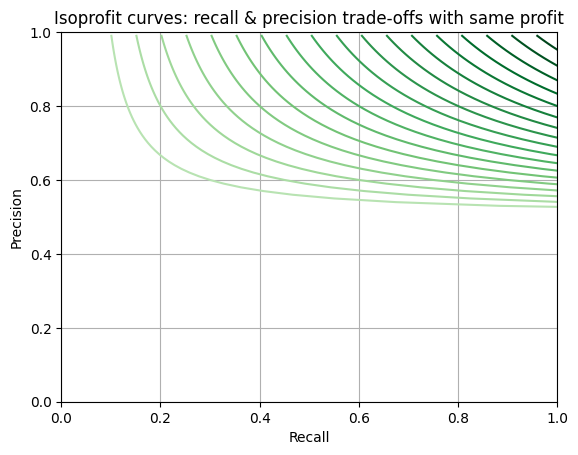

In [135]:
##### Visualising iso-profit curves #####

# creating series of profit and precision levels
profit_levels = [profit for profit in np.arange(0.1, 1, 0.05)]
isoprofit_precision = [pre for pre in np.arange(0.5, 1, 0.01)]

isoprofit_curves = []

# looping over profit levels
for profit_level in profit_levels:

    precision_scores = []
    recall_scores = []
    
    # calculating the implied recall score as a function of profit level and precision score
    for temp_precision in isoprofit_precision:
        temp_recall = profit_level / ((2*temp_precision - 1)/temp_precision)
        
        precision_scores.append(temp_precision)
        recall_scores.append(temp_recall)

    isoprofit_curves.append([recall_scores, precision_scores])
        
# plotting iso-profit curves
colors = plt.cm.Greens(np.linspace(0.3, 1, len(isoprofit_curves)))

plt.figure()

for line, color in zip(isoprofit_curves, colors):
    plt.plot(line[0], line[1], c=color)
    
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Isoprofit curves: recall & precision trade-offs with same profit")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

plt.show()

The lines in the graph above shows combinations of precision and recall scores that generate the same returns. The more to the right (or the higher) the line is - the higher profit. Having high recall but low precision means identifying/trading on a large share of the "up-days", i.e. when index returns are positive, but having a lot of the trading days actually end up being "down-days", i.e. when the index return is negative. Having low recall but high precision means trading on relatively few days, but often being right. As we can see from the graph no combinations have lower precision than 50%, because if TP/(FP+TP) is below 50% we would not be making any profits as the losses would cancel out the gains.

I will mainly use this profit metric to evaluate model performance.

### 2.4 PCA

In [136]:
##### Splitting numerical and dummy columns #####

# identifying dummy columns
dummy_cols = [col for col in X_train.columns if (X_train[col].nunique() == 2)]

# saving dummy columns
X_train_dummy = X_train[dummy_cols]
X_val_dummy = X_val[dummy_cols]
X_test_dummy = X_test[dummy_cols]

# saving numerical columns
X_train_num = X_train.drop(columns = dummy_cols)
X_val_num = X_val.drop(columns = dummy_cols)
X_test_num = X_test.drop(columns = dummy_cols)

<Axes: >

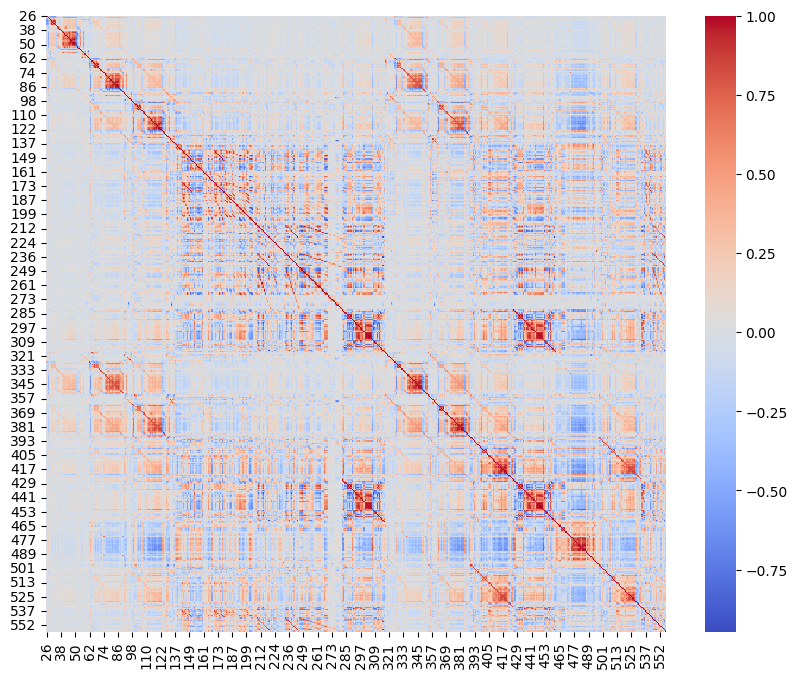

In [137]:
# plotting feature correlation
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_num.corr(), cmap='coolwarm')

In the correlation heatmap above we observe that several features are highly correlated. Since correlated features contain similar information, there is room to reduce complexity (features) without loosing too much information. We will therefore proceed and reduce the dimensionality of the data through PCA. However, prior to the PCA we will both center and scale the data since we are dealing with features in different units according to the assignment instructions.

In [138]:
##### PCA #####

# creating scaler
scaler = StandardScaler() 

# standardising numerical columns
X_train_num_std = scaler.fit_transform(X_train_num)
X_val_num_std = scaler.transform(X_val_num)
X_test_num_std = scaler.transform(X_test_num)

# PCA (includes all PC's initially)
rr, cc = X_train_num_std.shape
pca = PCA(n_components=cc, random_state=random_seed)

X_train_std_pca = pca.fit_transform(X_train_num_std)
X_val_std_pca = pca.transform(X_val_num_std)
X_test_std_pca = pca.transform(X_test_num_std)

# saving all z_scores to a dataframes
Z_train = pd.DataFrame(X_train_std_pca,
                       columns = [f"PC{i}" for i in range(1, X_train_std_pca.shape[1] + 1)],
                       index = X_train.index)

Z_val = pd.DataFrame(X_val_std_pca, 
                     columns = [f"PC{i}" for i in range(1, X_train_std_pca.shape[1] + 1)],
                     index = X_val.index)

Z_test = pd.DataFrame(X_test_std_pca, 
                     columns = [f"PC{i}" for i in range(1, X_train_std_pca.shape[1] + 1)],
                     index = X_test.index)

# concating dummies and PC's to gather feature data in dataframe
X_train_reduced_vF = pd.concat([X_train_dummy, Z_train], axis=1)
X_val_reduced_vF = pd.concat([X_val_dummy, Z_val], axis=1)
X_test_reduced_vF = pd.concat([X_test_dummy, Z_test], axis=1)

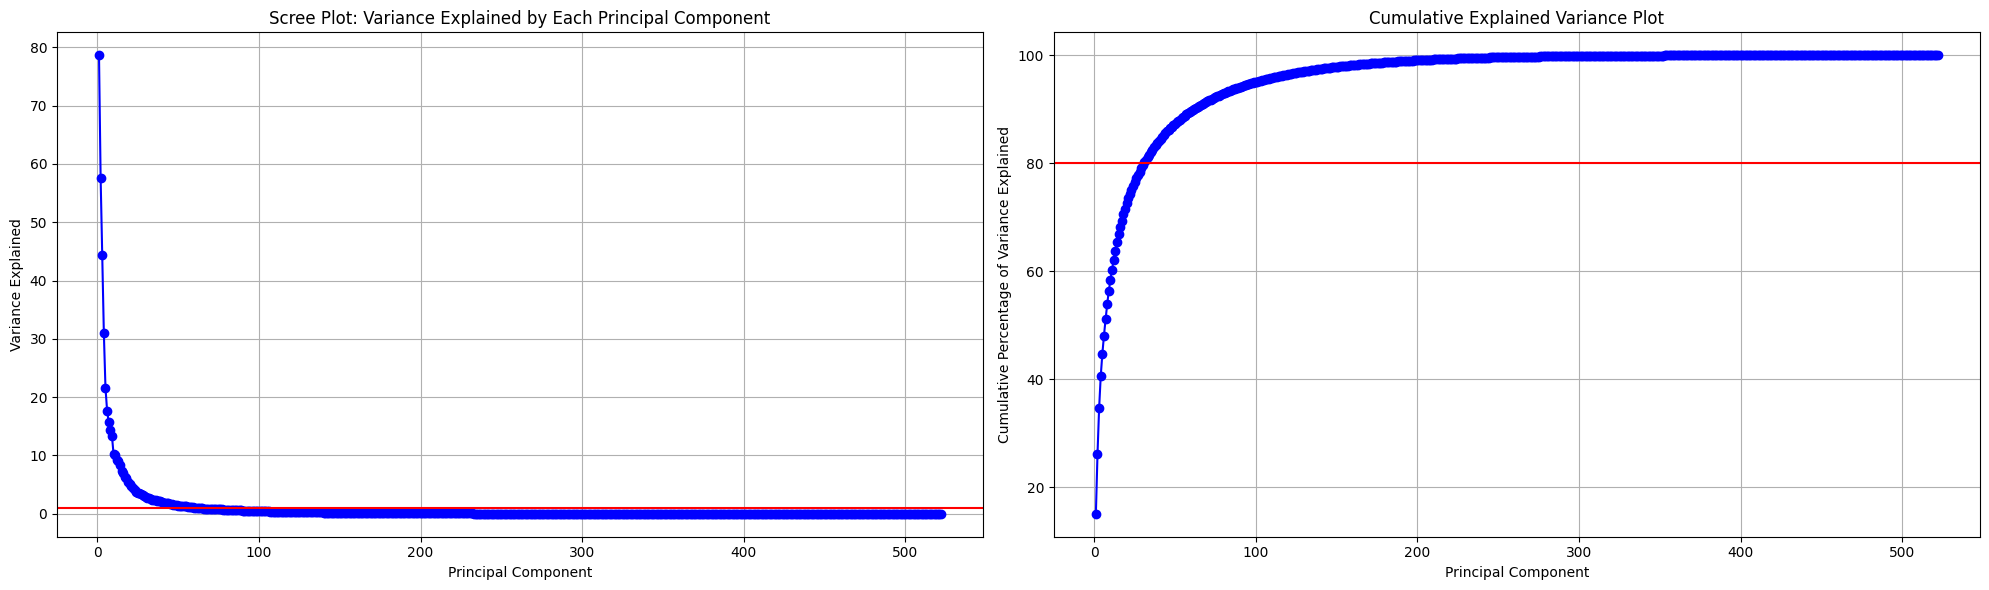

In [139]:
##### Plotting PCA #####

# preparing graph data
ve = pca.explained_variance_
pve = pca.explained_variance_ratio_ * 100
cpve = np.cumsum(pve)

df = pd.DataFrame({'PC': np.arange(1, len(ve) + 1), 
                   'var_exp': ve, 
                   'cum_var_exp': cpve})

# setting up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# scree Plot
ax1.plot(df['PC'], df['var_exp'], color="blue", marker='o', linestyle='-')
ax1.axhline(y = 1, color = 'r', linestyle = '-')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.set_title('Scree Plot: Variance Explained by Each Principal Component')
ax1.grid(True)

# cumulative explained variance 
ax2.plot(df['PC'], df['cum_var_exp'], color="blue", marker='o', linestyle='-')
ax2.axhline(y = 80, color = 'r', linestyle = '-')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Percentage of Variance Explained')
ax2.set_title('Cumulative Explained Variance Plot')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [140]:
# saving the number of PC's that has cumulative explanation of 60%, 70%, 80%, 90% and 100% of variance
num_of_pc_60 = df[df["cum_var_exp"] >= 60]["PC"].min()
num_of_pc_70 = df[df["cum_var_exp"] >= 70]["PC"].min()
num_of_pc_80 = df[df["cum_var_exp"] >= 80]["PC"].min()
num_of_pc_90 = df[df["cum_var_exp"] >= 90]["PC"].min()
num_of_pc_100 = X_train_std_pca.shape[1]

# printing
print("Number of PCs explaining 60%: ", num_of_pc_60)
print("Number of PCs explaining 70%: ", num_of_pc_70)
print("Number of PCs explaining 80%: ", num_of_pc_80)
print("Number of PCs explaining 90%: ", num_of_pc_90)
print("Number of PCs explaining 100%: ", num_of_pc_100, " (the original number of numerical features)")

Number of PCs explaining 60%:  11
Number of PCs explaining 70%:  18
Number of PCs explaining 80%:  31
Number of PCs explaining 90%:  62
Number of PCs explaining 100%:  522  (the original number of numerical features)


### 2.5 Time period and principal component analysis

Below we will analyse how many PCs and what time period to train our models on. We will do this by evaluating the performance of simple SVC and ANN models on different combinations of PCs and time periods. 

In [141]:
##### Analysing model performance of various PC and timeperiod combinations #####

# PC's and periods being investigated
num_pcs = [num_of_pc_60, num_of_pc_70, num_of_pc_80, num_of_pc_90, num_of_pc_100]
dates = ["1900-01-01", "2005-01-01", "2010-01-01", "2015-01-01", "2017-01-01"]

# instantiating the SVC model - (NN is included in loop since model structure depends on training data shape)
svc = SVC()

# list to save model performance metrics
pca_period_gridsearch = []

# looping over time period and PC combinations
for pcs in num_pcs:
    for date in dates:
    
        # modifying the data to the specific time period and PCs
        temp_train_X = X_train_reduced_vF.loc[date:, :f"PC{pcs}"]
        temp_train_y = y_train[date:]
        
        temp_val_X = X_val_reduced_vF.loc[date:, :f"PC{pcs}"]
        temp_val_y = y_val[date:]
    
        # instantiating NN model
        nn_model = keras.Sequential(
            [
                layers.Dense(32, activation="relu", kernel_initializer="uniform", input_dim = temp_train_X.shape[1]),
                layers.Dropout(0.5),
                layers.Dense(32, activation="relu", kernel_initializer="uniform"),
                layers.Dropout(0.5),
                layers.Dense(1,  kernel_initializer="uniform", activation = "sigmoid")
            ]
        )
        nn_model.compile(loss='binary_crossentropy', optimizer='adam')
        
        # fitting SVC model and calculating scores
        svc.fit(temp_train_X, temp_train_y)

        svc_val_pred = svc.predict(temp_val_X)
        svc_val_f1 = f1_score(temp_val_y, svc_val_pred)
        svc_val_acc = accuracy_score(temp_val_y, svc_val_pred)
        svc_val_recall = recall_score(temp_val_y, svc_val_pred)
        svc_val_precision = precision_score(temp_val_y, svc_val_pred)
        svc_val_profit = svc_val_recall * ((2*svc_val_precision - 1)/svc_val_precision)
        
        # fitting nn model and calculating scores
        nn_model.fit(temp_train_X, temp_train_y, shuffle = False, batch_size=1, epochs=3, verbose=0)

        nn_val_pred = (nn_model.predict(temp_val_X)[:,0] >= 0.5).astype(int)
        nn_val_f1 = f1_score(temp_val_y, nn_val_pred)
        nn_val_acc = accuracy_score(temp_val_y, nn_val_pred)
        nn_val_recall = recall_score(temp_val_y, nn_val_pred)
        nn_val_precision = precision_score(temp_val_y, nn_val_pred)
        nn_val_profit = nn_val_recall * ((2*nn_val_precision - 1)/nn_val_precision)

        # saving all model scores
        pca_period_gridsearch.append([pcs, date, 
                                      svc_val_profit, svc_val_f1, svc_val_acc,
                                      nn_val_profit, nn_val_f1, nn_val_acc])
        
# creating dataframe of model performance metrics
pca_period_gridsearch = pd.DataFrame(pca_period_gridsearch,
                                     columns = ["PCs", "date", 
                                                "svc_val_profit", "svc_val_f1", "svc_val_acc",
                                                "nn_val_profit", "nn_val_f1", "nn_val_acc"])        

39/39 [==============================] - 0s 345us/step


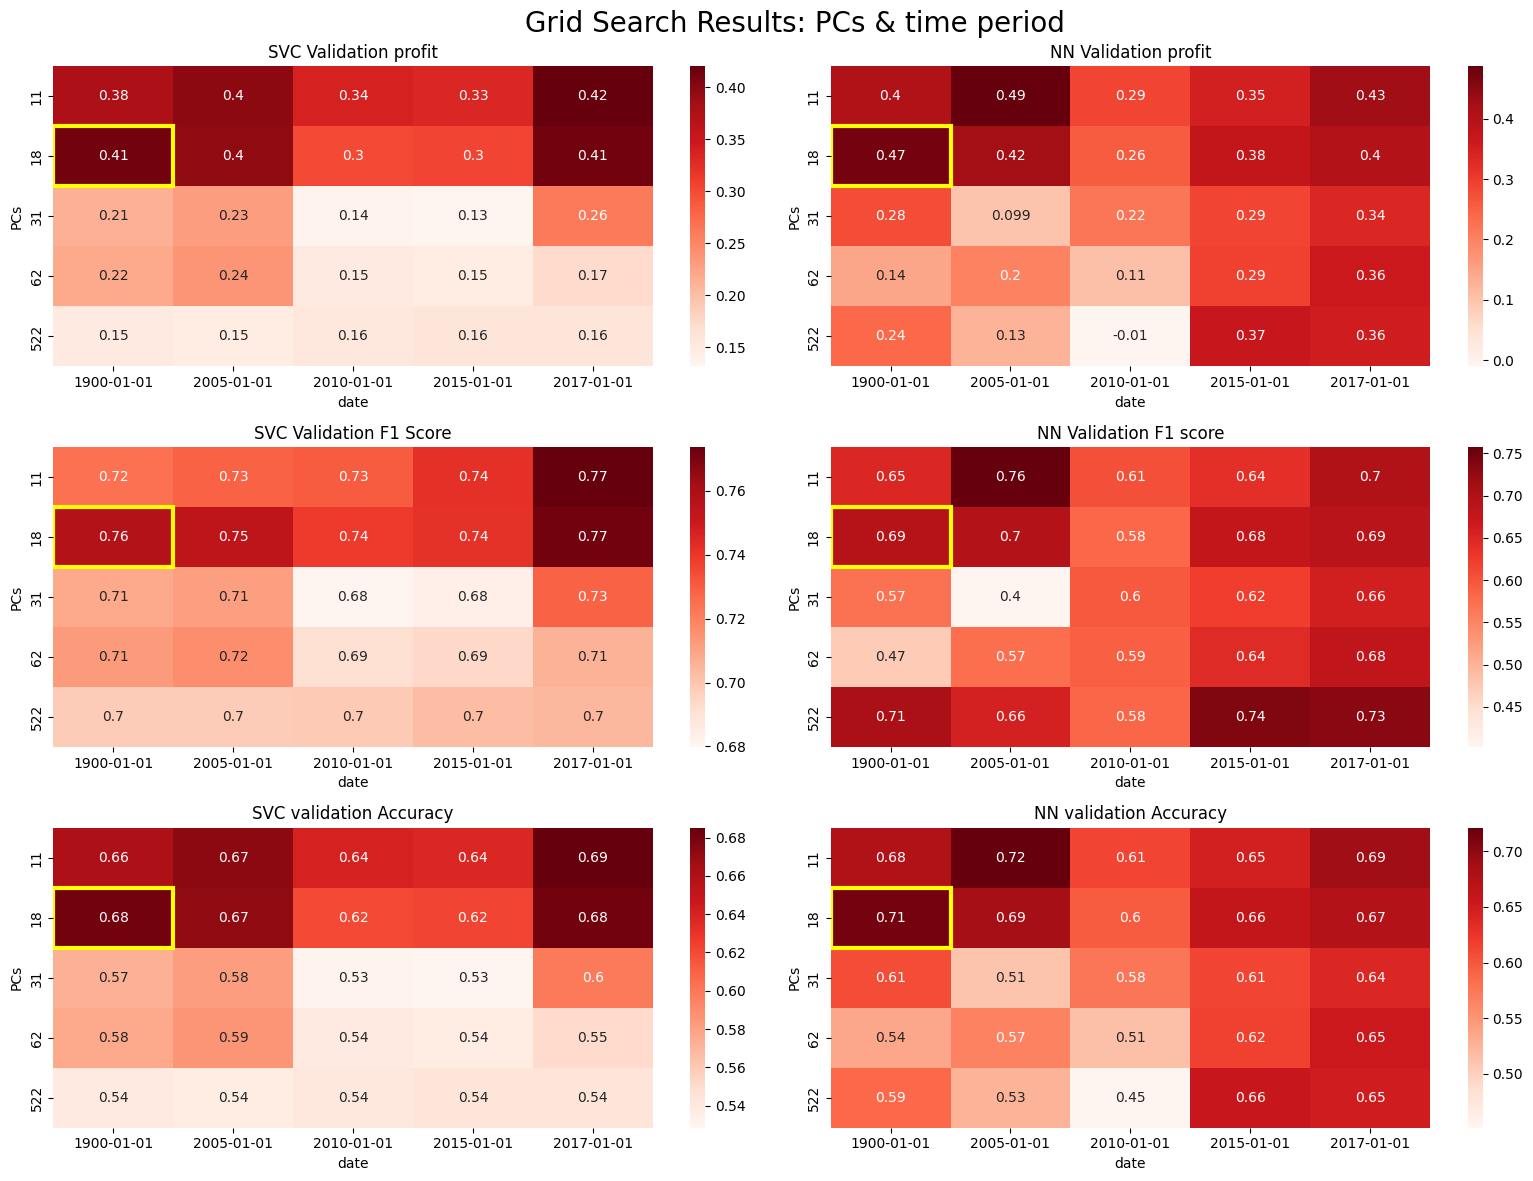

In [142]:
##### Plotting model performance depending on PC and timeperiod combinations #####

# creating subplot structure
fig, ax = plt.subplots(3, 2, figsize=(16, 12)) 
fig.suptitle("Grid Search Results: PCs & time period", fontsize=20)

# SVC validation profit
sns.heatmap(pca_period_gridsearch.pivot(index="PCs", columns="date", values="svc_val_profit"),
            cmap="Reds", annot=True, ax=ax[0, 0])
ax[0, 0].set_title("SVC Validation profit")

# NN validation profit
sns.heatmap(pca_period_gridsearch.pivot(index="PCs", columns="date", values="nn_val_profit"),
            cmap="Reds", annot=True, ax=ax[0, 1])
ax[0, 1].set_title("NN Validation profit")

# SVC validation F1 Score
sns.heatmap(pca_period_gridsearch.pivot(index="PCs", columns="date", values="svc_val_f1"),
            cmap="Reds", annot=True, ax=ax[1, 0])
ax[1, 0].set_title("SVC Validation F1 Score")

# NN validation F1 score
sns.heatmap(pca_period_gridsearch.pivot(index="PCs", columns="date", values="nn_val_f1"),
            cmap="Reds", annot=True, ax=ax[1, 1])
ax[1, 1].set_title("NN Validation F1 score")

# SVC validation Accuracy
sns.heatmap(pca_period_gridsearch.pivot(index="PCs", columns="date", values="svc_val_acc"),
            cmap="Reds", annot=True, ax=ax[2, 0])
ax[2, 0].set_title("SVC validation Accuracy")

# NN validation Accuracy
sns.heatmap(pca_period_gridsearch.pivot(index="PCs", columns="date", values="nn_val_acc"),
            cmap="Reds", annot=True, ax=ax[2, 1])
ax[2, 1].set_title("NN validation Accuracy")

# adding patches to emphasize best PC and time period combination
for rr in range(0,3):
    for cc in range(0,2):
        ax[rr, cc].add_patch(patches.Rectangle((0, 1), 1,1, fill=False, edgecolor='yellow', lw=3))

plt.tight_layout()
plt.show()


**Visualistion overview:**

Above, we can see how well a SVC and an ANN model performs depending on the time period of the training data and the number of principals components trained on. To save computational complexity the models are not tuned, instead default hyperparameter settings are used for SVC and the neural network has a relatively simple structure. The "date" axis represents the earliest date from which data is used, thus "1900-01-01" includes all available time periods. The "PCs" axis represents the number of principal components used. 522 is the total number of PCs and thus is the equivalent of not reducing the data at all. To ensure that the data is transformed as intended I have double-checked that the performance of models trained on all the 522 PCs & "1900-01-01" is identical to that of a model trained on all non-PCA transformed data. I have not included these control calculations in this report to save space.

**Metric selection justification:**

To evaluate model performance I have primairly used profit (see section 2.3 for more information). I have in the figure above also included accuracy and f1-score. I included accuracy as it is a common and intuitive metric to evaluate model performance. I included the f1-score as it captures two central aspects of the ultimate problem we are trying to solve. When selecting which days to trade on we want to make sure that: 

1) We are able to identify a sufficient number of days (ex. as stated in the instructions we would not want a model to just suggest trading on 10 out of 125 days)
2) Of the suggested trades, we want as many as possible to actually be an "up-day" (ex. if trade suggestions consist of 50% True Positives and 50% False Positives we would not be making any money, assuming gains equals losses in absolute terms)

The first point relates to recall - TP/(TP+FN) - or what share of "up-days" our model is able to identify. The second point relates to precision - TP/(TP+FP) - or what share of the model's positive predictions actually end up being "up-days". The f1-score is the harmonic mean of precision and recall and is calculated as:

$F1\text{ score} = \frac{2 \times \text{recall} \times \text{precision}}{\text{recall} + \text{precision}}$

**Analysis and conclusion:**

When selecting what PCs and time period to choose I have mainly focused on the profit metrics of the models. Out of the best performing PC and time period combinations I was more inclined to take a longer time frame as this included more data and reduced the risk of simply performing well due to chance. I have not included LSTM in this analysis to reduce complexity, and standardise the format of training data (LSTM requires chronological data sequences).

We will proceed by finetuning models on the following data set:

 - 18 PCs using all available data from a time perspective
 

In [143]:
##### Finalising the dataframes that will be used for model training #####

# creating final version X datasets
X_train_vF = X_train_reduced_vF.loc["1900-01-01":,:f"PC{num_of_pc_70}"]
X_val_vF = X_val_reduced_vF.loc["1900-01-01":,:f"PC{num_of_pc_70}"]
X_test_vF = X_test_reduced_vF.loc["1900-01-01":,:f"PC{num_of_pc_70}"]

# creating final version y datasets
y_train_vF = y_train["1900-01-01":]
y_val_vF = y_val["1900-01-01":]
y_test_vF = y_test["1900-01-01":]

## 3. Model training

In this section I will train and evaluate various models.

### 3.1 SVC - Standard

In [144]:
##### Tuning SVC #####

# hyperparameter settings tested
param_grid = {'C': [0.0001, 0.001, 0.1, 1, 2, 5, 10, 25, 50, 100], 
              'gamma': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1]}

svc_tuning = []

# looping through hyperparameter combinations
for c_temp in param_grid["C"]:
    for gamma_temp in param_grid["gamma"]:
        
        # fitting svc
        svc = SVC(C = c_temp,
                  gamma = gamma_temp)
        
        svc.fit(X_train_vF, y_train_vF)

        # predicting data
        pred_on_train = svc.predict(X_train_vF)
        pred_on_val = svc.predict(X_val_vF)
        
        # performance of predictions
        train_acc = accuracy_score(y_train_vF, pred_on_train)
        train_f1 = f1_score(y_train_vF, pred_on_train)
        train_pre = precision_score(y_train_vF, pred_on_train)
        train_recall = recall_score(y_train_vF, pred_on_train)
        train_profit = train_recall * ((2*train_pre - 1)/train_pre)
        
        val_acc = accuracy_score(y_val_vF, pred_on_val)
        val_f1 = f1_score(y_val_vF, pred_on_val)
        val_pre = precision_score(y_val_vF, pred_on_val)
        val_recall = recall_score(y_val_vF, pred_on_val)
        val_profit = val_recall * ((2*val_pre - 1)/val_pre)
        
        # saving performance metrics
        svc_tuning.append([c_temp, gamma_temp, 
                           train_acc, train_f1, train_profit,
                           val_acc, val_f1, val_profit])        

# creating dataframe of model performance
svc_tuning = pd.DataFrame(svc_tuning,
                          columns = ["c", "gamma", 
                                     "train_acc", "train_f1", "train_profit",
                                     "val_acc", "val_f1", "val_profit"])

# retrieving the hyperparameter settings that have achieve the best profit on validation data
svc_best_c = svc_tuning.loc[svc_tuning.val_profit.idxmax()]["c"]
svc_best_gamma = svc_tuning.loc[svc_tuning.val_profit.idxmax()]["gamma"]

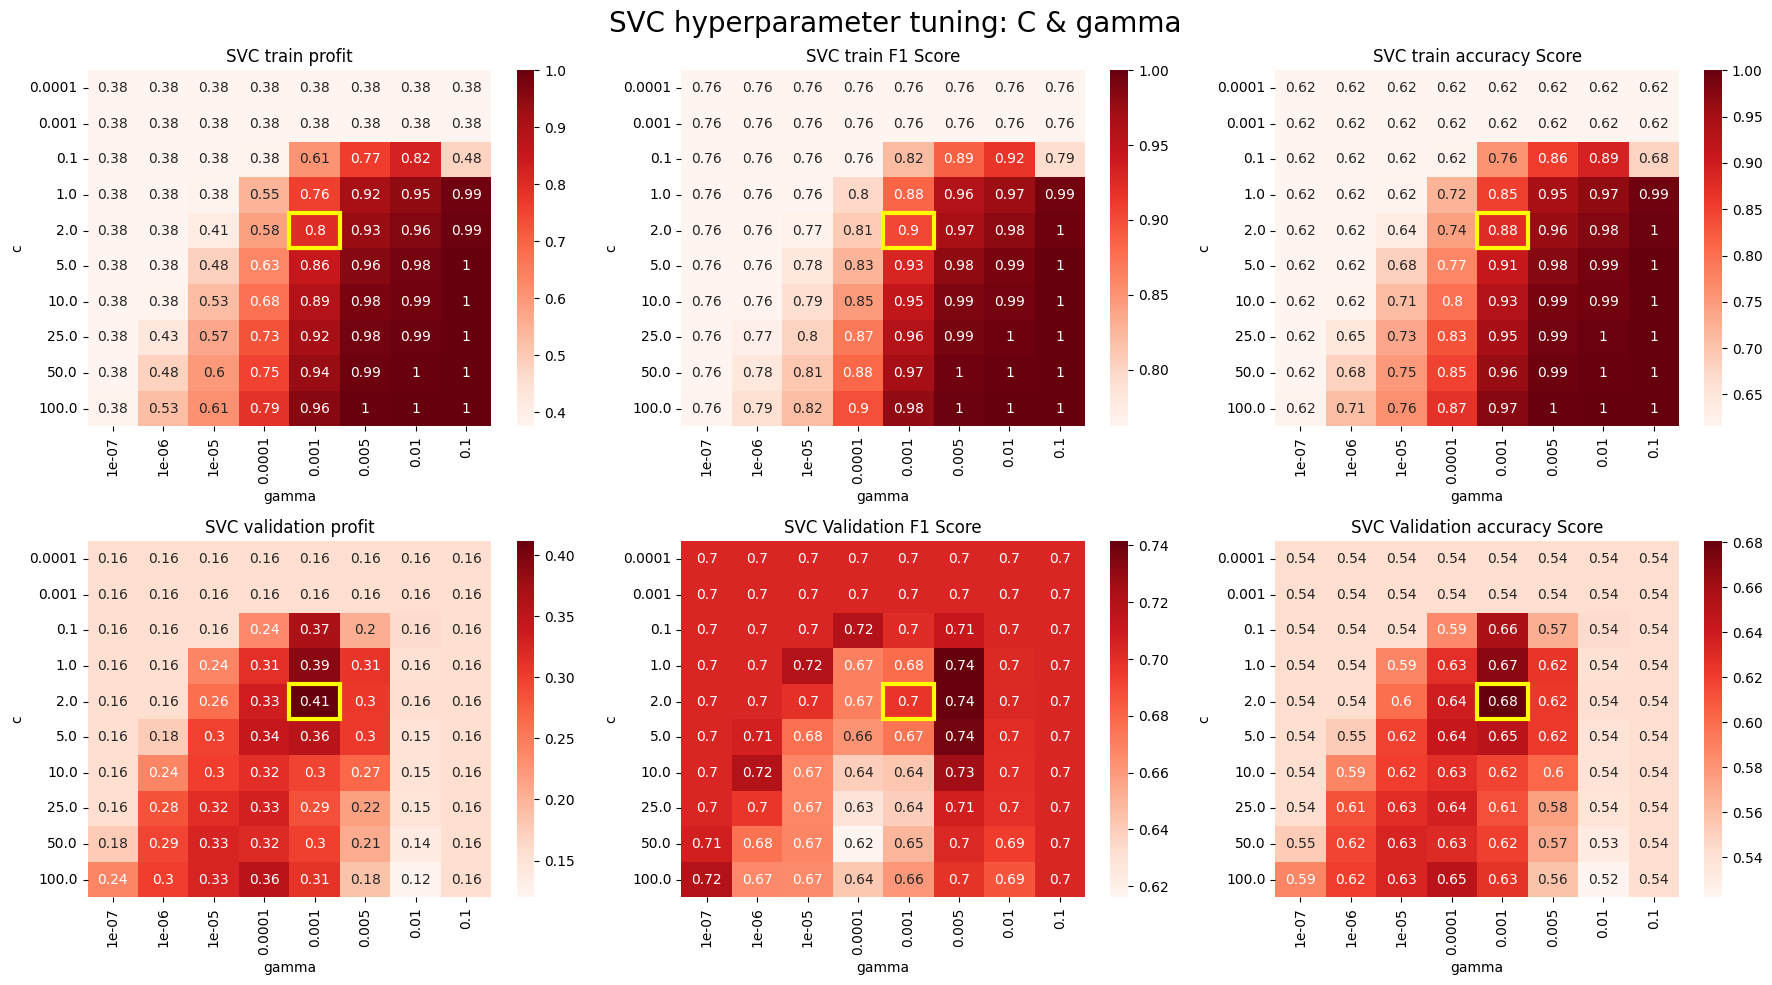

Best C:  2.0
Best gamma:  0.001


In [145]:
##### Plotting SVC tuning #####

# initialize subplot structure
fig, ax = plt.subplots(2, 3, figsize=(18, 10)) 

fig.suptitle("SVC hyperparameter tuning: C & gamma", fontsize=20)

# SVC train profit
sns.heatmap(svc_tuning.pivot(index="c", columns="gamma", values="train_profit"),
            cmap="Reds", annot=True, ax=ax[0,0])
ax[0,0].set_title("SVC train profit")

# SVC validation profit
sns.heatmap(svc_tuning.pivot(index="c", columns="gamma", values="val_profit"),
            cmap="Reds", annot=True, ax=ax[1,0])
ax[1,0].set_title("SVC validation profit")

# SVC train f1-score
sns.heatmap(svc_tuning.pivot(index="c", columns="gamma", values="train_f1"),
            cmap="Reds", annot=True, ax=ax[0,1])
ax[0,1].set_title("SVC train F1 Score")

# SVC validation f1-score
sns.heatmap(svc_tuning.pivot(index="c", columns="gamma", values="val_f1"),
            cmap="Reds", annot=True, ax=ax[1,1])
ax[1,1].set_title("SVC Validation F1 Score")

# SVC train accuracy
sns.heatmap(svc_tuning.pivot(index="c", columns="gamma", values="train_acc"),
            cmap="Reds", annot=True, ax=ax[0,2])
ax[0,2].set_title("SVC train accuracy Score")

# SVC validation accuracy
sns.heatmap(svc_tuning.pivot(index="c", columns="gamma", values="val_acc"),
            cmap="Reds", annot=True, ax=ax[1,2])
ax[1,2].set_title("SVC Validation accuracy Score")

# adding patches to emphasize best hyperparameter combination
for rr in range(0,2):
    for cc in range(0,3):
        ax[rr,cc].add_patch(patches.Rectangle((param_grid["gamma"].index(svc_best_gamma),
                                             param_grid["C"].index(svc_best_c)),
                                            1,1, fill=False, edgecolor='yellow', lw=3))

plt.tight_layout()
plt.show()

print("Best C: ", svc_best_c)
print("Best gamma: ", svc_best_gamma)


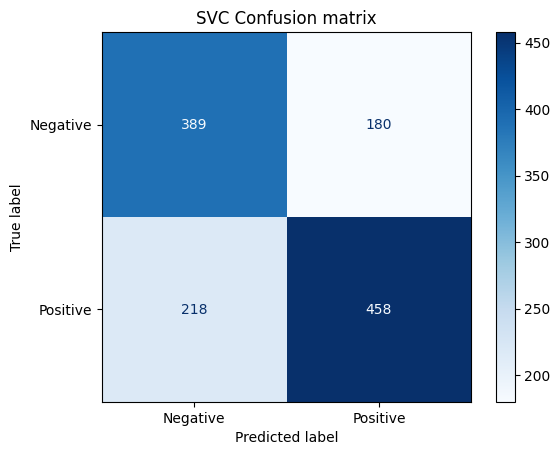

Default model profit (458-180): 278
Default model recall 458/(218+458): 0.68
Default model precision 458/(180+458): 0.72 



In [146]:
##### Plotting SVC confusion matrix #####

# fitting model based on best hyperparameters 
svc_best = SVC(C = svc_best_c,
              gamma = svc_best_gamma)


svc_best.fit(X_train_vF, y_train_vF)

# predicting validation data
y_val_pred_standardsvc = svc_best.predict(X_val_vF)

# creating confusion matrix
conf_matrix_default = confusion_matrix(y_val_vF, y_val_pred_standardsvc)

disp = ConfusionMatrixDisplay(conf_matrix_default, 
                              display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")

plt.title("SVC Confusion matrix")
plt.show()

print(f"Default model profit ({conf_matrix_default[1,1]}-{conf_matrix_default[0,1]}): {conf_matrix_default[1,1]-conf_matrix_default[0,1]}")
print(f"Default model recall {conf_matrix_default[1,1]}/({conf_matrix_default[1,0]}+{conf_matrix_default[1,1]}): {round(recall_score(y_val_vF, y_val_pred_standardsvc),2)}")
print(f"Default model precision {conf_matrix_default[1,1]}/({conf_matrix_default[0,1]}+{conf_matrix_default[1,1]}): {round(precision_score(y_val_vF, y_val_pred_standardsvc),2)}", "\n")

From the confusion matrix we can see that the SVC performance seems fairly balanced. The classification does not look skewed towards any direction. The model seems to be able to find a decent share of the true "updays" (High TP, low FN) and have fairly good/pure recommendations (High TP, low FP).

To see if the SVC performance can be improved further, I will add some more complexity to the SVC model in the next section. I will introducing probability to the SVC model, through platt scaling, which increases flexibility and control over the model and its decision boundry.

### 3.2 SVC - Platt scaling

In section 3.1, SVC have been tuned in the classical way. I wanted to experiment with some additional techniques and therefore included this section.

In this section I will see if I can improve performance further, by experimenting with platt scaling. SVC is a non-probabalistic model since observations are classified depending on what side of the hyperplane they lie on. Platt scaling introduces probability by fitting a logistic regression, taking the observations' distance from the hyperplane as feature data and true label as target variable. Through this model adjustment we are able to change the threshold, which essentially means shifting the hyperplane to find an optimal balance between TP, FP, TN and FN to our specific problem. I will find this optimal balance by calculating the impact on profit.

#### 3.2.1 Conceptual overview of platt scaling

In this subsection, I will apply platt scaling to the best performing hyperparameter settings found in section "3.1 SVC - Standard" to visualise how platt scaling can be used to adjust the decision boundry of the model (the hyperplane). Platt scaling is built into Scikit-learn and the SVC model and is activated through setting "probability = True". https://scikit-learn.org/stable/modules/svm.html

In [147]:
##### Applying platt scaling to the previously tuned model #####

# fit SVC with probabilities through platt scaling
svc_best_platt = SVC(C = svc_best_c,
                     gamma = svc_best_gamma,
                     probability = True)
svc_best_platt.fit(X_train_vF, y_train_vF)

# predict validation data
val_prob = svc_best_platt.predict_proba(X_val_vF)[:,-1]

# get precision-recall curve of model
precision, recall, thresholds = precision_recall_curve(y_val_vF, val_prob)
auc_precision_recall = auc(recall, precision)

# saving precision-recall curve to df
profit_max_curve = pd.DataFrame([precision[:-1], recall[:-1]], 
                      columns=thresholds,
                      index = ["precision", "recall"]).T
    
# calculating profit for each threshold
profit_max_curve["profit"] = profit_max_curve["recall"] * ((2*profit_max_curve["precision"] - 1) / profit_max_curve["precision"])  

# creating the isoprofit curve of profit-maximising threshold
isoprofit_precision = [i for i in np.arange(profit_max_curve["precision"][profit_max_curve.profit.idxmax()]-0.20,
                                            profit_max_curve["precision"][profit_max_curve.profit.idxmax()]+0.30, 
                                            0.01)]
isoprofit_recall = [profit_max_curve.profit.max()/((2*i-1)/i) for i in isoprofit_precision]

# saving thresholds to plot
default_model_threshold = profit_max_curve[profit_max_curve.precision == precision_score(y_val_vF, y_val_pred_standardsvc)].index[0]
profit_max_model_threshold = profit_max_curve.profit.idxmax()

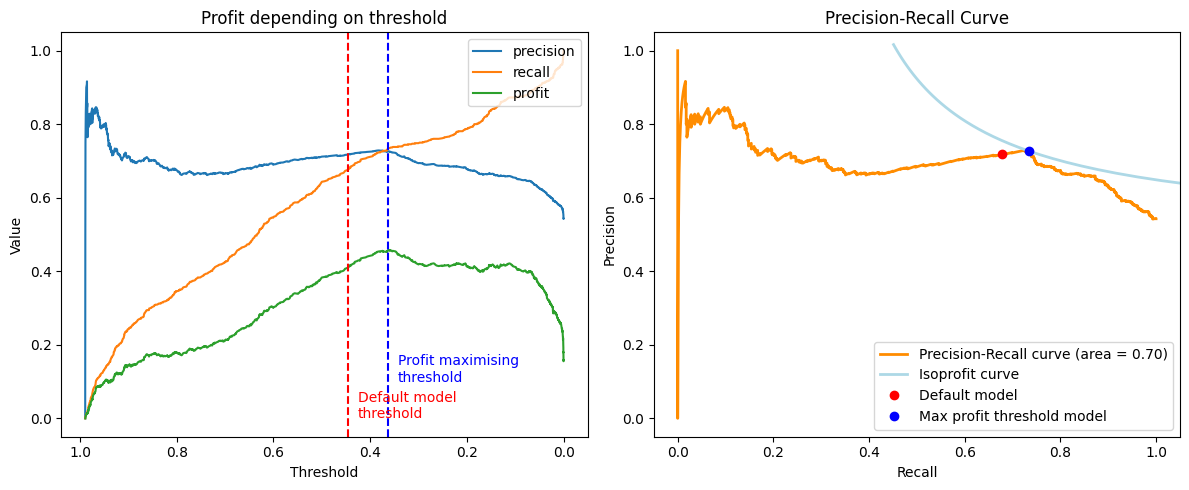

In [148]:
##### Visualsing platt scaling of the previously tuned model #####

# create subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

# plot left graph
axs[0].plot(profit_max_curve, label=["precision", "recall", "profit"])
axs[0].axvline(x=default_model_threshold, color='red', linestyle='--')
axs[0].axvline(x=profit_max_model_threshold, color='blue', linestyle='--')
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("Value")
axs[0].set_title('Profit depending on threshold')
axs[0].legend(loc="upper right")
axs[0].invert_xaxis()

# annotate the profit-maximising and default threshold
axs[0].annotate('Default model\nthreshold', 
                xy=(default_model_threshold, 0.1), 
                xytext=(default_model_threshold - 0.02, 0), 
                ha='left',
                color = "red")

axs[0].annotate('Profit maximising\nthreshold', 
                xy=(profit_max_model_threshold, 0.1), 
                xytext=(profit_max_model_threshold - 0.02, 0.1), 
                ha='left',
                color = "blue")

# plot right graph
axs[1].plot(recall, precision, color='darkorange', 
            lw=2, label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')

axs[1].plot(isoprofit_recall, isoprofit_precision, 
            color='lightblue', lw=2, label='Isoprofit curve')

axs[1].plot(recall_score(y_val_vF, y_val_pred_standardsvc), precision_score(y_val_vF, y_val_pred_standardsvc), 
            'ro', label="Default model")

axs[1].plot(profit_max_curve["recall"][profit_max_curve.profit.idxmax()], 
            profit_max_curve["precision"][profit_max_curve.profit.idxmax()], 
            'bo', label="Max profit threshold model")

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="best")
axs[1].set_ylim(-0.05, 1.05)
axs[1].set_xlim(-0.05, 1.05)

# layout and plot
plt.tight_layout()
plt.show()


As we can see from the **left graph** above, precision, recall and implied profit varies depending on how we shift the decision boundry. When the threshold is set to zero the model suggests trading every day (note that the threshold axis is reversed to mirror the direction of the precision-recall curve). As a result recall is 1 (we trade on all "up-days") but the precision is poor and equal to the share of "up-days" of total number of trading days in the validation data. When the threshold is increased, recall drops as the number of False Negatives increase but precision increases since False Positives typically drops at a faster rate than the True Positives.

The **right graph** visualise the trade-off between recall and precision. The red point indicates the recall and precision scores achieved by the default model and the blue point indicates the optimal threshold from a profit perspective. The lightblue isoprofit curve shows recall-precision combinations that would result in the same profit as the blue point - naturally there are no thresholds on the precision-recall curve that have a higher profit than the profit maximising threshold. Worth noting is that we are able to observe the precision-recall curve thanks to the platt scaling. Without platt scaling we would only have the option of the default model, but with platt scaling we are able to "shift" the hyperplane which is visualised by the curve.

The **key take-away** from both of these graphs is that introducing probability through platt scaling increases the flexability of the model as we can adjust the threshold and that the default threshold is not necessairly the best from a profit-maximising perspective.

Below we will look closer at the confusion matrix of the two models

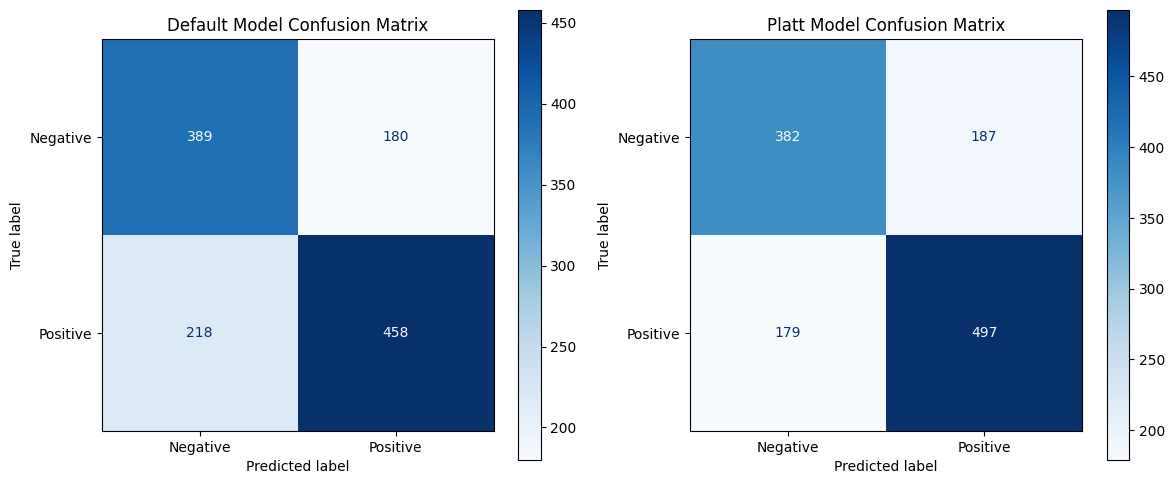

Default model profit (458-180): 278
Default model recall 458/(218+458): 0.68
Default model precision 458/(180+458): 0.72 

Platt model profit (497-187): 310
Platt model recall 497/(179+497): 0.74
Platt model precision 497/(187+497): 0.73


In [149]:
##### Plotting confusion matrices #####

# calculate predictions based on thresholds
default_pred = (val_prob >= default_model_threshold).astype(int)
platt_pred = (val_prob >= profit_max_model_threshold).astype(int)

# create confusion matrices
conf_matrix_default = confusion_matrix(y_val_vF, default_pred)
conf_matrix_platt = confusion_matrix(y_val_vF, platt_pred)

# create subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot default model confusion matrix
disp_default = ConfusionMatrixDisplay(conf_matrix_default, display_labels=["Negative", "Positive"])
disp_default.plot(ax=axs[0], cmap='Blues')  # Plot in the first subplot
axs[0].set_title('Default Model Confusion Matrix')

# plot platt model confusion matrix
disp_platt = ConfusionMatrixDisplay(conf_matrix_platt, display_labels=["Negative", "Positive"])
disp_platt.plot(ax=axs[1], cmap='Blues')  # Plot in the second subplot
axs[1].set_title('Platt Model Confusion Matrix')

plt.tight_layout()
plt.show()

# visualise calculations to achieve metrics of interest
print(f"Default model profit ({conf_matrix_default[1,1]}-{conf_matrix_default[0,1]}): {conf_matrix_default[1,1]-conf_matrix_default[0,1]}")
print(f"Default model recall {conf_matrix_default[1,1]}/({conf_matrix_default[1,0]}+{conf_matrix_default[1,1]}): {round(recall_score(y_val_vF, default_pred),2)}")
print(f"Default model precision {conf_matrix_default[1,1]}/({conf_matrix_default[0,1]}+{conf_matrix_default[1,1]}): {round(precision_score(y_val_vF, default_pred),2)}", "\n")

print(f"Platt model profit ({conf_matrix_platt[1,1]}-{conf_matrix_platt[0,1]}): {conf_matrix_platt[1,1]-conf_matrix_platt[0,1]}")
print(f"Platt model recall {conf_matrix_platt[1,1]}/({conf_matrix_platt[1,0]}+{conf_matrix_platt[1,1]}): {round(recall_score(y_val_vF, platt_pred),2)}")
print(f"Platt model precision {conf_matrix_platt[1,1]}/({conf_matrix_platt[0,1]}+{conf_matrix_platt[1,1]}): {round(precision_score(y_val_vF, platt_pred),2)}")

Above we can see the confusion martix of the default SVC model we created in section 3.1 as well as the confusion matrix of the model with the same hyperparameters, but with a profit-maximising threshold. Looking at profit, which is what we really care about, we can see that we can achieve better trading through shifting the threshold (again assuming that gains and losses are equally big in absolute terms).

In the analysis above we have seen that the default decision boundry (the hyperplane) is not necessairily optimal from a profit-maximizing perspective. Now, the question is if we can incorporate this into the hyperparameter tuning and model construction to create an SVC that is better than the standard version.

#### 3.2.2 Hyperparameter tuning with platt scaling

In [150]:
##### Hyperparameter tuning with platt scaling #####

# store the results and curves data
svc_tuning = []

# looping through hyperparameter combinations
for c_temp in param_grid["C"]:
    for gamma_temp in param_grid["gamma"]:

        # fit SVC model with platt scaling (probability = True)
        svc = SVC(C=c_temp, gamma=gamma_temp, probability=True, random_state=random_seed)
        svc.fit(X_train_vF, y_train_vF)

        # predict validation data
        val_prob = svc.predict_proba(X_val_vF)[:, 1] 

        # get precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_val_vF, val_prob)
        auc_precision_recall = auc(recall, precision)
        
        # save precision-recall curve
        svc_tuning.append([c_temp, gamma_temp, auc_precision_recall, recall, precision, thresholds])

# converting results into df
svc_tuning = pd.DataFrame(svc_tuning, columns=["C", "gamma", "auc", "recall", "precision", "thresholds"])

# save hyperparameter setting with highest precision-recall AUC
plattsvc_best_c = svc_tuning.loc[svc_tuning["auc"].idxmax()]["C"]
plattsvc_best_gamma = svc_tuning.loc[svc_tuning["auc"].idxmax()]["gamma"]

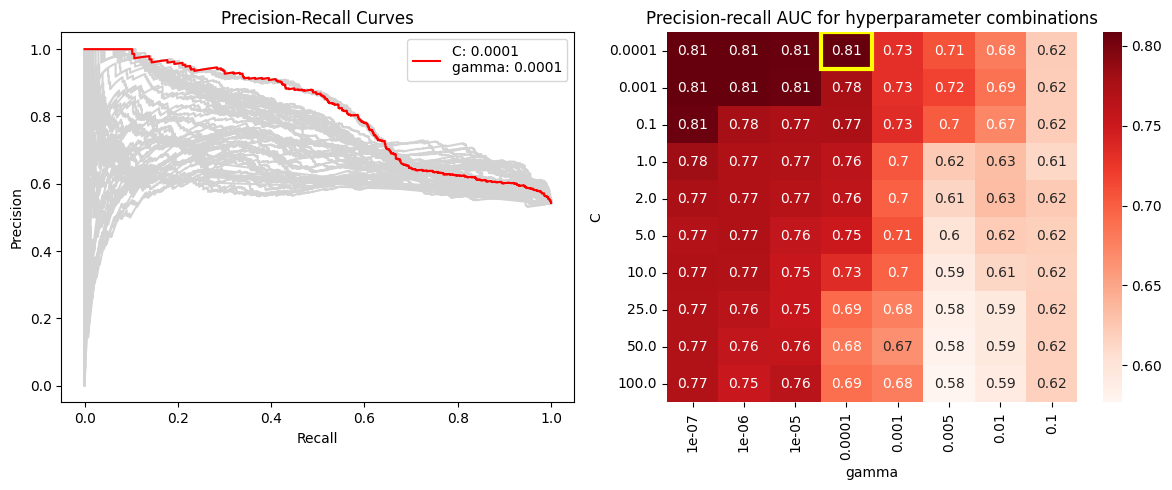

Best C:  0.0001
Best gamma:  0.0001


In [151]:
##### Visualise hyperparameter tuning with platt scaling #####

# create subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# left: plot precision-recall curves of all hyperparameter combinations in lightgray
for i, row in svc_tuning.iterrows():
    axs[0].plot(row.recall, row.precision, color="lightgrey")

# left: plot the curve with maximum AUC in red 
auc_max_curve = svc_tuning.loc[svc_tuning["auc"].idxmax()]
axs[0].plot(auc_max_curve.recall, auc_max_curve.precision, color="red",
               label=f"C: {auc_max_curve.C}\ngamma: {auc_max_curve.gamma}")
axs[0].legend(loc="best")
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curves')

# right: plot the precision-recall AUC heatmap
heatmap_data = svc_tuning.pivot(columns="gamma", index="C", values="auc")
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt='.2g', ax=axs[1])
axs[1].set_title('Precision-recall AUC for hyperparameter combinations')
axs[1].add_patch(patches.Rectangle((param_grid["gamma"].index(plattsvc_best_gamma), 
                                    param_grid["C"].index(plattsvc_best_c)),
                                   1,1, fill=False, edgecolor='yellow', lw=3))

plt.tight_layout()
plt.show()

# print best hyperparameter settings
print("Best C: ", plattsvc_best_c)
print("Best gamma: ", plattsvc_best_gamma)

Since we now have probability estimates, we do not immediately tune for profit. Instead we want to find the hyperparameters that lead to the best performance for all thresholds. We do this by tuning for the largest area under the precision-recall curve. In the **left graph** we can see that the hyperparameters with the highest AUC performs particulairly well for high thresholds, while there are other hyperparameters that perform better than the AUC-maximising parameters at lower threshold levels. If the investment fund had a particular risk profile this could influence what hyperparameters to use, we will however proceed with the AUC-maximising hyperparameters in this case. In the **right graph** we can see the AUC on validation data of various C and Gamma combinations.

In [152]:
##### Determine best threshold based on combinations of training and validation subsets #####

# create a k-fold that splits data into 3 cronological subsets
kf = KFold(n_splits=3, shuffle=False) 

# create (platt) SVC model with best hyperparameter settings
best_plattsvc = SVC(C = plattsvc_best_c,
                    gamma= plattsvc_best_gamma,
                    probability=True,
                    random_state=random_seed)

curve_data = []

# looping through combinations of training and validation data subsets
for i, (_, train_index) in enumerate(kf.split(X_train_vF)):
    temp_X_train = X_train_vF.iloc[train_index]
    temp_y_train = y_train_vF.iloc[train_index]

    for j, (_, val_index) in enumerate(kf.split(X_val_vF)):
        temp_X_test = X_val_vF.iloc[val_index]
        temp_y_test =  y_val_vF.iloc[val_index]
    
        # fitting and predicting on subsets
        best_plattsvc.fit(temp_X_train, temp_y_train)

        val_prob = best_plattsvc.predict_proba(temp_X_test)[:, 1]
        
        # obtain precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(temp_y_test, val_prob)
        
        # calculate profit for each threshold
        for threshold, precision, recall in zip(thresholds, precisions, recalls):
            profit = recall * ((2 * precision - 1) / precision)
            curve_data.append([i, j, threshold, recall, precision, profit])


# save results to df
curve_data_df = pd.DataFrame(curve_data,
                             columns = ["train_subset", "val_subset", "threshold", "recall", "precision", "profit"])
curve_data_df.threshold = round(curve_data_df.threshold, 2)
curve_data_df = curve_data_df.groupby(["train_subset", "val_subset", "threshold"]).mean()

/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_18574/2981885495.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  profit = recall * ((2 * precision - 1) / precision)
/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_18574/2981885495.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  profit = recall * ((2 * precision - 1) / precision)
/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_18574/2981885495.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  profit = recall * ((2 * precision - 1) / precision)
/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_18574/2981885495.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  profit = recall * ((2 * precision - 1) / precision)
/var/folders/hj/0cz950bj1px72xgp3lkv40lm0000gn/T/ipykernel_18574/2981885495.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  profit = recall * ((2 * precision - 1) / precision)
/var/folders/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


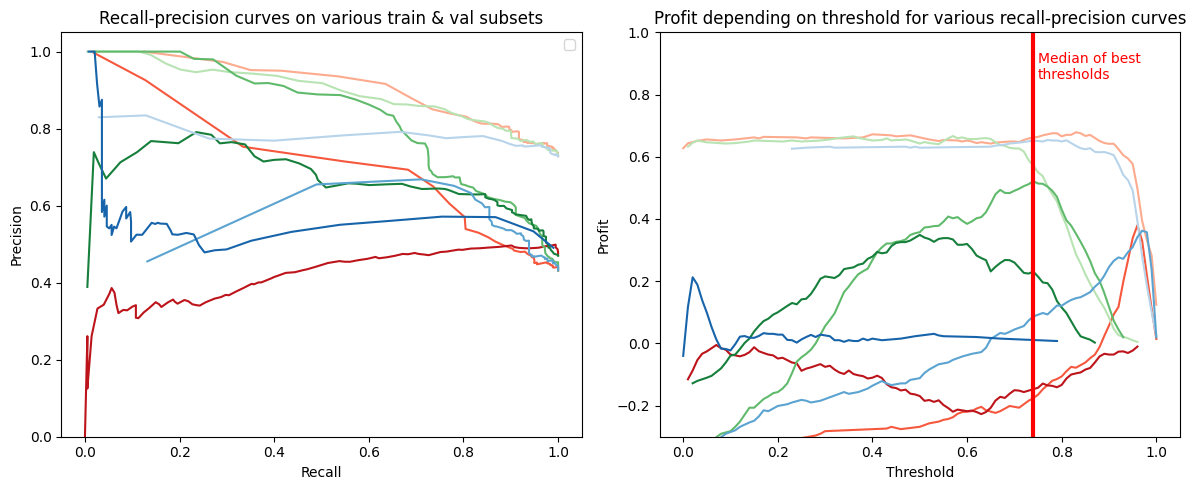

Best threshold:  0.74


In [153]:
##### Plotting best threshold based on combinations of training and validation subsets #####

# creating subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# customising colors
colors = np.hstack([[[plt.cm.Reds(np.linspace(0.3, 0.8, 3))]],
                    [[plt.cm.Greens(np.linspace(0.3, 0.8, 3))]],
                    [[plt.cm.Blues(np.linspace(0.3, 0.8, 3))]]])[0]

# left: plot precision-recall curves
for train_index, val_index in curve_data_df.reset_index(level="threshold").index.unique():
    axs[0].plot(curve_data_df.loc[train_index,val_index]["recall"], 
                curve_data_df.loc[train_index,val_index]["precision"],
                color = colors[train_index,val_index])
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_ylim(0,1.05)
axs[0].set_title("Recall-precision curves on various train & val subsets")
axs[0].legend()    
    
# right: plot how threshold affects profit for each precision-recall curve
optimal_thresholds = []

for train_index, val_index in curve_data_df.reset_index(level="threshold").index.unique():
    optimal_threshold = curve_data_df.loc[train_index, val_index].idxmax()["profit"]
    axs[1].plot(curve_data_df.loc[train_index,val_index].index,
                curve_data_df.loc[train_index,val_index]["profit"],
                color = colors[train_index,val_index])
    optimal_thresholds.append(optimal_threshold)
    
# right: calculate profit-maximising threshold
plattsvc_best_threshold = round(np.median(optimal_thresholds),2)

axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("Profit")
axs[1].set_title("Profit depending on threshold for various recall-precision curves")
axs[1].axvline(plattsvc_best_threshold, color="red", lw=3)
axs[1].set_ylim(-0.3, 1)

axs[1].annotate('Median of best\nthresholds', 
                xy=(plattsvc_best_threshold, 0.9), 
                xytext=(plattsvc_best_threshold + 0.01, 0.85), 
                ha='left',
                color = "red")

plt.tight_layout()
plt.show()

print("Best threshold: ", round(plattsvc_best_threshold, 2))

In order to get a more robuste estimate of the best threshold I have split the training and validation data into subsets. I have then trained and evaluated an SVC, with the AUC-maximising hyperparameter settings, on all combinations of train and validation subsets. In the **left graph** we can see that the recall-precision curves varies quite alot depending on the data it is trained and evaluated on. In the **right graph** I have plotted the profit as a function of threshold for the various recall-precision curves. By taking the median of the various curves' profit-maximising thresholds I obtain an estimate of the optimal threshold, which I will use for the final platt scaled SVC model.

In [154]:
# reshaping the auc-maximising curve for plotting
auc_max_curve = pd.DataFrame([auc_max_curve.thresholds,
                              auc_max_curve.precision,
                              auc_max_curve.recall],
                             index = ["threshold", "precision", "recall"]).T
auc_max_curve.threshold = round(auc_max_curve.threshold, 2)
auc_max_curve = auc_max_curve.groupby("threshold").mean()

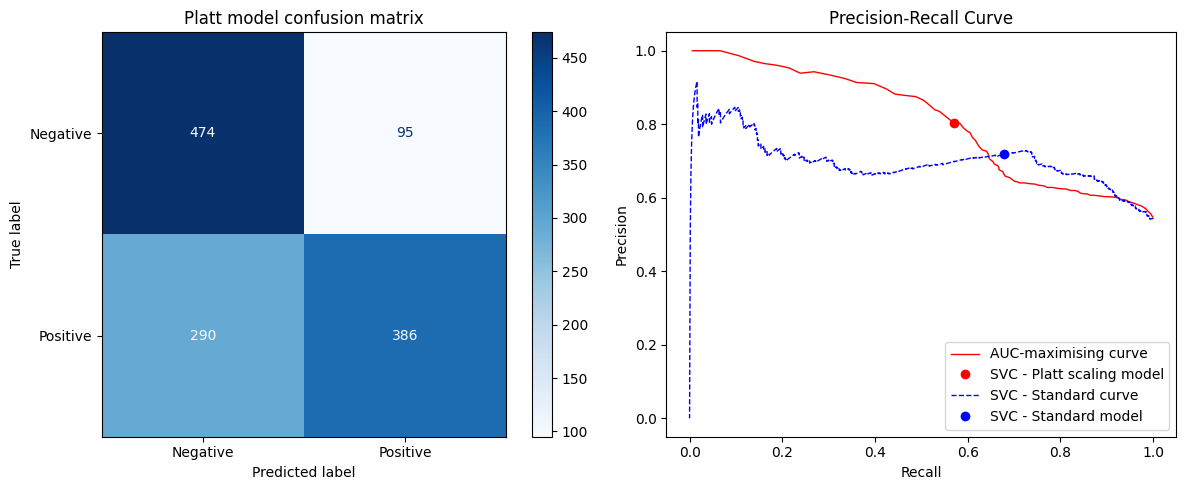

Platt model profit (386-95): 291
Platt model recall 386/(290+386): 0.74
Platt model precision 386/(95+386): 0.73


In [155]:
##### Plotting platt svc confusion matrix and precision-recall curve #####

# create subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

# fitting final model and predicting validation data based on best threshold
best_plattsvc.fit(X_train_vF, y_train_vF)

val_prob = best_plattsvc.predict_proba(X_val_vF)[:,-1]
y_val_pred_plattsvc = (val_prob >= plattsvc_best_threshold).astype(int)

# left: plot confusion matrix
conf_matrix_platt = confusion_matrix(y_val_vF, y_val_pred_plattsvc)
disp_platt = ConfusionMatrixDisplay(conf_matrix_platt, display_labels=["Negative", "Positive"])
disp_platt.plot(cmap='Blues', ax = axs[0]) 
axs[0].set_title('Platt model confusion matrix')

# right: platt svc precision-recall curve (and standard svc precision-recall curve)
axs[1].plot(auc_max_curve.recall, auc_max_curve.precision, 
            color="red", lw=1, label=f"AUC-maximising curve")

axs[1].plot(auc_max_curve.loc[plattsvc_best_threshold, "recall"],
            auc_max_curve.loc[plattsvc_best_threshold, "precision"], 
            "ro", lw = 3, label = "SVC - Platt scaling model")

axs[1].plot(profit_max_curve.recall, profit_max_curve.precision, 
            color='blue', lw=1, linestyle = "--", label=f'SVC - Standard curve')

axs[1].plot(recall_score(y_val_vF, y_val_pred_standardsvc), 
            precision_score(y_val_vF, y_val_pred_standardsvc),
            'bo', lw=3, label="SVC - Standard model")

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="best")
axs[1].set_ylim(-0.05, 1.05)
axs[1].set_xlim(-0.05, 1.05)

# layout and plot
plt.tight_layout()
plt.show()

# visualise calculations to achieve metrics of interest
print(f"Platt model profit ({conf_matrix_platt[1,1]}-{conf_matrix_platt[0,1]}): {conf_matrix_platt[1,1]-conf_matrix_platt[0,1]}")
print(f"Platt model recall {conf_matrix_platt[1,1]}/({conf_matrix_platt[1,0]}+{conf_matrix_platt[1,1]}): {round(recall_score(y_val_vF, platt_pred),2)}")
print(f"Platt model precision {conf_matrix_platt[1,1]}/({conf_matrix_platt[0,1]}+{conf_matrix_platt[1,1]}): {round(precision_score(y_val_vF, platt_pred),2)}")

While platt scaling and threshold optimisation led to a slightly higher profit than the standard SVC, it still performes roughly in line with the standard SVC model. An interesting insight from this analysis, however, is that they perform very differently at higher thresholds. Despite similar returns at profit-maximising threshold level, platt scaling could still benefit the riskaverse investor as the performance varies more at higher threshold levels.

Note that the "SVC - Standard curve" is not really part of the standard SVC model as a normal SVC, without platt scaling, does not have a precision-recall curve - the standard SVC model is simply represented by the "SVC - Standard model" point in the right graph. I included the precision-recall curve of the platt scaled standard model for visualisation reasons.

### 3.3 ANN

In [156]:
##### Creating functions to calculate profit #####

# function for tensorflow models (tf scales automatically)
def custom_profit_metric_tf(y_true, y_pred):
    
    # cast to float32
    y_true = tf.cast(y_true, tf.float32)  
    y_pred = tf.cast(y_pred, tf.float32)
    
    # convert probabilities to binary values
    y_pred = tf.round(y_pred)  

    # true positives
    tp = tf.reduce_sum(y_true * y_pred)  
    
    # false positives
    fp = tf.reduce_sum(y_pred) - tp  
    
    return tp - fp

# function for calculating profit manually
def custom_profit_metric(y_true, y_pred):
    
    # cast to float32
    y_true = tf.cast(y_true, tf.float32)  
    y_pred = tf.cast(y_pred, tf.float32)  
    
    # convert probabilities to binary values
    y_pred = tf.round(y_pred)
    
    tp = tf.reduce_sum(y_true * y_pred)  # true positives
    fp = tf.reduce_sum(y_pred) - tp  # false positives
    fn = tf.reduce_sum(y_true) - tp  # false negatives

    precision = tp / (tp + fp + tf.keras.backend.epsilon()) # epsilon to aviod dividing by zero
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    profit = recall * ((2 * precision - 1) / (precision + tf.keras.backend.epsilon()))
    
    return profit

In [157]:
##### Create neural network model #####

# setting up model structure
nn_model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", kernel_initializer="uniform", bias_initializer='uniform', input_dim = X_train_vF.shape[1]),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu", kernel_initializer="uniform", bias_initializer='uniform'),
        layers.Dropout(0.5),
        layers.Dense(1,  kernel_initializer="uniform", activation = "sigmoid")
    ]
)

# compiling model
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 
                                                                        tfa.metrics.F1Score(num_classes = 1, threshold = 0.5),
                                                                        keras.metrics.Precision(), 
                                                                        keras.metrics.Recall(),
                                                                        custom_profit_metric_tf])

nn_model.summary()

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_331 (Dense)           (None, 64)                3520      
                                                                 
 dropout_218 (Dropout)       (None, 64)                0         
                                                                 
 dense_332 (Dense)           (None, 64)                4160      
                                                                 
 dropout_219 (Dropout)       (None, 64)                0         
                                                                 
 dense_333 (Dense)           (None, 1)                 65        
                                                                 
Total params: 7745 (30.25 KB)
Trainable params: 7745 (30.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [158]:
##### Train neural network model #####

# setting up checkpoint - to enable retrieving best performing model
checkpoint_path = path+"/ann_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      save_weights_only=True, 
                                      save_best_only=True, 
                                      monitor='val_custom_profit_metric_tf', 
                                      mode='max', verbose=0)

# training model
nn_results = nn_model.fit(x = X_train_vF, 
                          y = y_train_vF, 
                          epochs = 10,
                          batch_size = 1, 
                          shuffle= False,
                          validation_data = (X_val_vF, y_val_vF),
                          callbacks=[checkpoint_callback],
                          verbose=0)

# loading best performing model
nn_model.load_weights(checkpoint_path) 

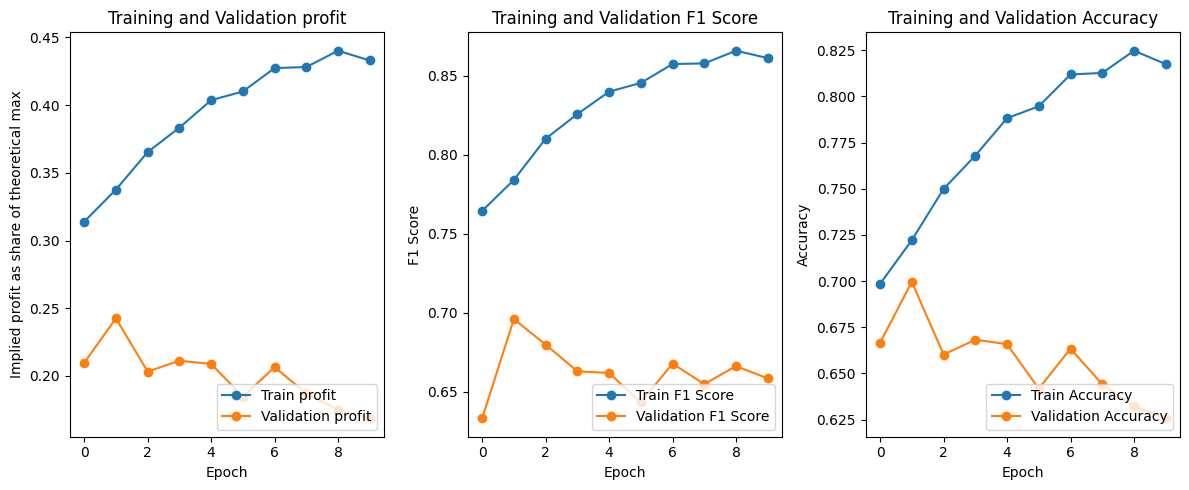

Best epoch for early stopping:  2


In [159]:
##### Plotting neural network performance #####

# create subplot structure
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# plotting profit
axs[0].plot(nn_results.history['custom_profit_metric_tf'], '-o', label='Train profit')  
axs[0].plot(nn_results.history['val_custom_profit_metric_tf'], '-o', label='Validation profit')
axs[0].set_ylabel('Implied profit as share of theoretical max')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation profit')

# plotting f1-score
axs[1].plot(nn_results.history['f1_score'], '-o', label='Train F1 Score')  
axs[1].plot(nn_results.history['val_f1_score'], '-o', label='Validation F1 Score')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='lower right')
axs[1].set_title('Training and Validation F1 Score')

# plotting accuracy
axs[2].plot(nn_results.history['accuracy'], '-o', label='Train Accuracy') 
axs[2].plot(nn_results.history['val_accuracy'], '-o', label='Validation Accuracy')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='lower right')
axs[2].set_title('Training and Validation Accuracy')

plt.tight_layout()  
plt.show() 

# save and print optimal number of epochs for early stopping
ann_best_epoch = np.argmax(nn_results.history['val_custom_profit_metric_tf']) + 1
print("Best epoch for early stopping: ", ann_best_epoch)


39/39 [==============================] - 0s 330us/step


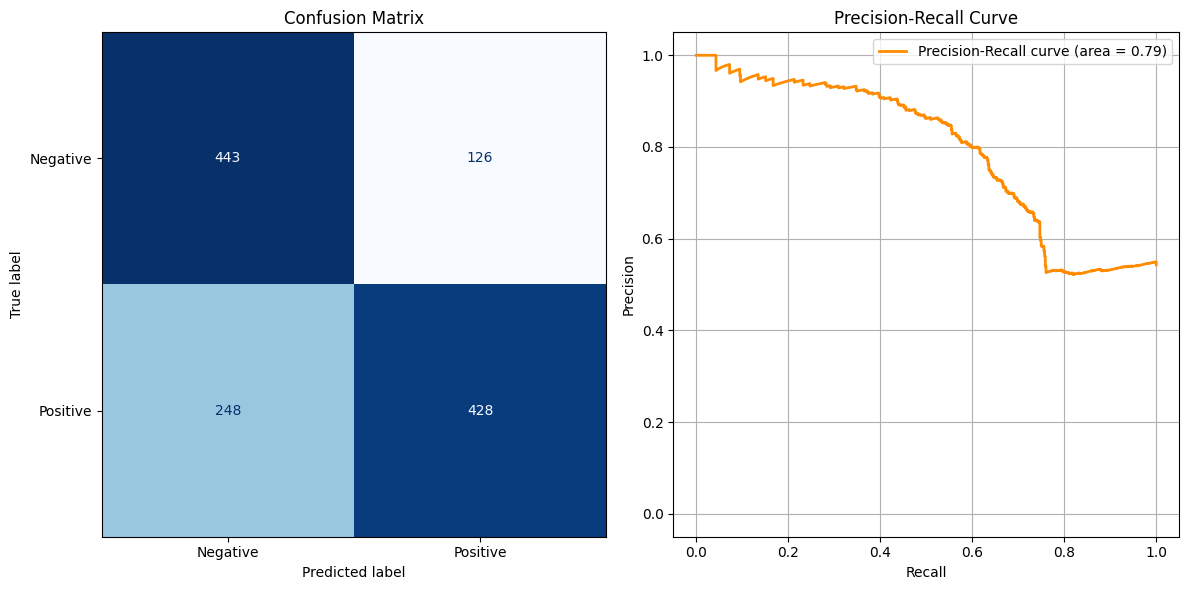

Platt model profit (428-126): 302
Platt model recall 428/(248+428): 0.63
Platt model precision 428/(126+428): 0.77


In [160]:
##### plotting neural network confusion matrix and precision-recall curve #####

# creating confusion matrix
y_val_pred_ann = (nn_model.predict(X_val_vF)>0.5).astype("int").flatten()
nn_conf_matrix = confusion_matrix(y_val_vF, y_val_pred_ann)
disp = ConfusionMatrixDisplay(nn_conf_matrix, 
                              display_labels=["Negative", "Positive"])

# retrieving precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_vF, 
                                                       nn_model.predict(X_val_vF))
auc_precision_recall = auc(recall, precision)

# setting up subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# left: plotting confusion matrix
disp.plot(cmap="Blues", ax = axs[0], colorbar= False)
axs[0].set_title('Confusion Matrix')

# right: precision-recall curve
axs[1].plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="best")
axs[1].set_ylim(-0.05, 1.05)
axs[1].grid()

plt.tight_layout()
plt.show()

# visualise calculations to achieve metrics of interest
print(f"Platt model profit ({nn_conf_matrix[1,1]}-{nn_conf_matrix[0,1]}): {nn_conf_matrix[1,1]-nn_conf_matrix[0,1]}")
print(f"Platt model recall {nn_conf_matrix[1,1]}/({nn_conf_matrix[1,0]}+{nn_conf_matrix[1,1]}): {round(recall_score(y_val_vF, y_val_pred_ann),2)}")
print(f"Platt model precision {nn_conf_matrix[1,1]}/({nn_conf_matrix[0,1]}+{nn_conf_matrix[1,1]}): {round(precision_score(y_val_vF, y_val_pred_ann),2)}")


In creating and tuning the ANN model I have experimented with different number of layers, dropout layers, different size layers, activation functions and batch-sizes. This tuning as been iterative and the final ANN model design is a result of this. I have also utilised early stopping to limit overfitting.

### 3.4 LSTM
#### 3.4.1 Data transformation
LSTM models expect the data to be in a different format the SVC and ANN models. I will reshape the data for LSTM purposes below.

In [161]:
##### Function to transform data into format expected by LSTM models #####

def transform_data_to_sequence(X_df, y_df, days_per_seq, step):    
    X_mtr = X_df.values
    y_mtr = y_df.values
    
    X_sequenced = []
    y_sequenced = []
    y_index = []

    # looping through index    
    for i in range(days_per_seq-1, len(y_df), step): 
        
        # X-values are the feature values for the specified number of sequence days
        xvalues = X_mtr[i-days_per_seq+1:i+1,:]
        yvalue = y_mtr[i]
        
        # features, target variable and index are saved
        X_sequenced.append(xvalues)
        y_sequenced.append(yvalue)
        y_index.append(y_df.index[i])
        
    # returns reshaped data
    return np.array(X_sequenced), np.array(y_sequenced), np.array(y_index)

In [162]:
##### Transforming data #####

X_train_lstm, y_train_lstm, train_ind_lstm = transform_data_to_sequence(X_train_vF, y_train_vF, 10, 1)
X_val_lstm, y_val_lstm, val_ind_lstm = transform_data_to_sequence(X_val_vF, y_val_vF, 10, 1)
X_test_lstm, y_test_lstm, test_ind_lstm = transform_data_to_sequence(X_test_vF, y_test_vF, 10, 1)

#### 3.4.2 Fitting and evaluating model

In [163]:
##### Creating lstm model #####
lstm_model = keras.Sequential([
    layers.LSTM(32, input_shape=(10, X_train_vF.shape[1]), dropout=0.5, return_sequences=True),
    layers.LSTM(32, dropout=0.5),
    layers.Dense(1)
])        

lstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", 
             tfa.metrics.F1Score(num_classes = 1, threshold = 0.5),
             custom_profit_metric_tf],
)

lstm_model.summary()

Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 32)            11136     
                                                                 
 lstm_10 (LSTM)              (None, 32)                8320      
                                                                 
 dense_334 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19489 (76.13 KB)
Trainable params: 19489 (76.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [164]:
##### Training lstm model #####

checkpoint_path = "lstm_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      save_weights_only=True, 
                                      save_best_only=True, 
                                      monitor='val_custom_profit_metric_tf', 
                                      mode='max', 
                                      verbose=0)

lstm_results = lstm_model.fit(x = X_train_lstm, 
                              y = y_train_lstm, 
                              validation_data = [X_val_lstm, y_val_lstm], 
                              batch_size = 1,
                              shuffle = False,
                              epochs = 10,
                              callbacks=[checkpoint_callback],
                              verbose=0)

lstm_model.load_weights(checkpoint_path) 

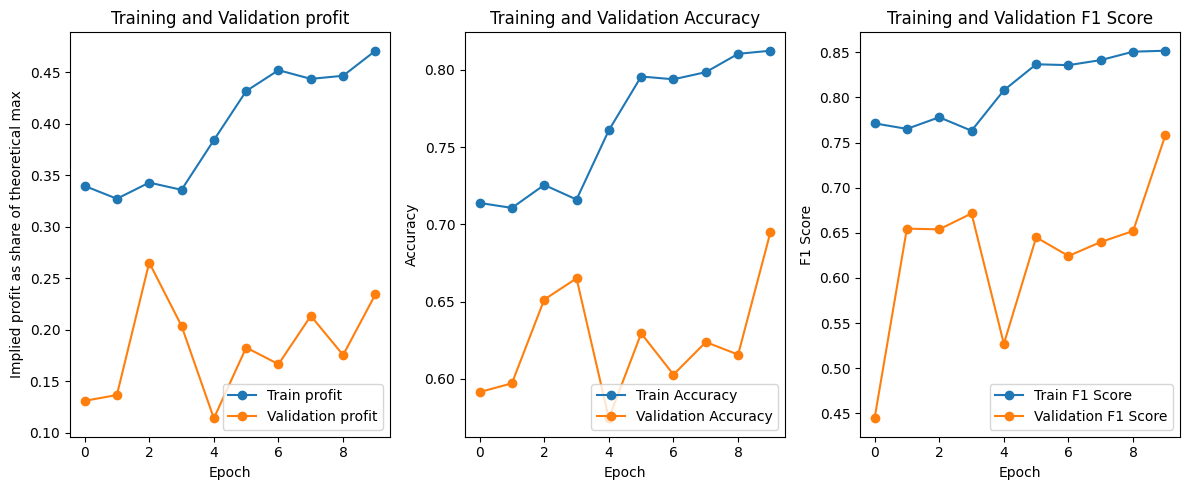

LSTM model's best epoch for early stopping:  3


In [165]:
##### Plotting lstm performance #####

# create subplot structure
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# plotting profit
axs[0].plot(lstm_results.history['custom_profit_metric_tf'], '-o', label='Train profit')  # 'o' is to show the markers, '-' is to draw the line
axs[0].plot(lstm_results.history['val_custom_profit_metric_tf'], '-o', label='Validation profit')
axs[0].set_ylabel('Implied profit as share of theoretical max')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation profit')

# plotting accuracy
axs[1].plot(lstm_results.history['accuracy'], '-o', label='Train Accuracy')  # 'o' is to show the markers, '-' is to draw the line
axs[1].plot(lstm_results.history['val_accuracy'], '-o', label='Validation Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='lower right')
axs[1].set_title('Training and Validation Accuracy')

# plotting f1-score
axs[2].plot(lstm_results.history['f1_score'], '-o', label='Train F1 Score')  # 'o' is to show the markers, '-' is to draw the line
axs[2].plot(lstm_results.history['val_f1_score'], '-o', label='Validation F1 Score')
axs[2].set_ylabel('F1 Score')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='lower right')
axs[2].set_title('Training and Validation F1 Score')

plt.tight_layout() 
plt.show()  

# save and print optimal number of epochs for early stopping
lstm_best_epoch = np.argmax(lstm_results.history['val_custom_profit_metric_tf']) + 1
print("LSTM model's best epoch for early stopping: ", lstm_best_epoch)

39/39 [==============================] - 0s 941us/step


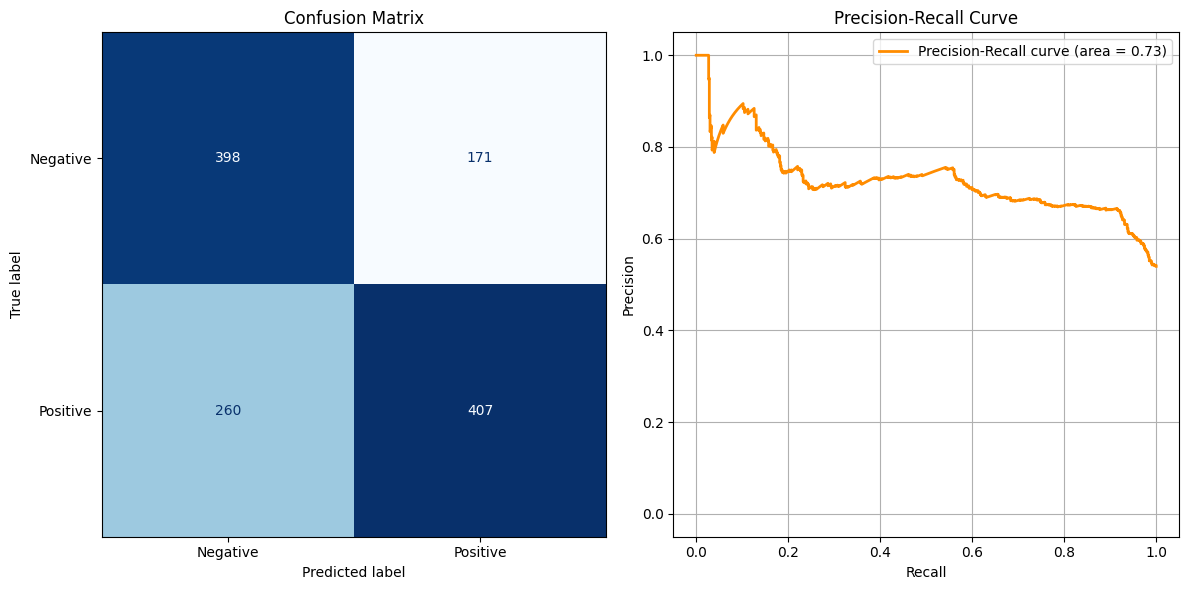

Platt model profit (407-171): 236
Platt model recall 407/(260+407): 0.61
Platt model precision 407/(171+407): 0.7


In [166]:
##### plotting lstm confusion matrix and precision-recall curve #####

# creating confusion matrix
y_val_pred_lstm = (lstm_model.predict(X_val_lstm)>0.5).astype("int").flatten()

lstm_conf_matrix = confusion_matrix(y_val_lstm, y_val_pred_lstm)

disp = ConfusionMatrixDisplay(lstm_conf_matrix, 
                              display_labels=["Negative", "Positive"])


# retrieving precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val_lstm, 
                                                       lstm_model.predict(X_val_lstm))
auc_precision_recall = auc(recall, precision)

# setting up subplot structure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# left: plotting confusion matrix
disp.plot(cmap="Blues", ax=axs[0], colorbar=False)
axs[0].set_title('Confusion Matrix')

# right: precision-recall curve
axs[1].plot(recall, precision, color='darkorange', lw=2, 
            label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="best")
axs[1].set_ylim(-0.05, 1.05)
axs[1].grid()

plt.tight_layout()
plt.show()

# visualise calculations to achieve metrics of interest
print(f"Platt model profit ({lstm_conf_matrix[1,1]}-{lstm_conf_matrix[0,1]}): {lstm_conf_matrix[1,1]-lstm_conf_matrix[0,1]}")
print(f"Platt model recall {lstm_conf_matrix[1,1]}/({lstm_conf_matrix[1,0]}+{lstm_conf_matrix[1,1]}): {round(recall_score(y_val_lstm, y_val_pred_lstm),2)}")
print(f"Platt model precision {lstm_conf_matrix[1,1]}/({lstm_conf_matrix[0,1]}+{lstm_conf_matrix[1,1]}): {round(precision_score(y_val_lstm, y_val_pred_lstm),2)}")

In creating and tuning the lstm model I have experimented with different sequence lengths, sequence overlaps, number of layers, dropout layers, different size layers, activation functions and batch-sizes. This tuning as been iterative and the final lstm model design shown above is a result of this. I have also utilised early stopping to limit overfitting.

## 4. Model performance summary
### 4.1 Naive classifier
In order to evaluate the performance of the models I also want to see what a naive classifier, a classifier that categorises all days as being "up-days" would achieve on different metrics. This is relevant because we would not want to use a model that performs worse than a simple naive classifier.

In [167]:
# calculating scores of naive classifier
naive_val_pred = np.ones(len(y_val_vF))

naive_val_profit = custom_profit_metric(y_val_vF, naive_val_pred).numpy()
naive_val_acc = accuracy_score(y_val_vF, naive_val_pred)
naive_val_f1 = f1_score(y_val_vF, naive_val_pred)

# printing scores of naive classifier
print("Naive profit: ", naive_val_profit)
print("Naive accuracy: ", naive_val_acc)
print("Naive f1-score: ", naive_val_f1)

Naive profit:  0.15828407
Naive accuracy:  0.5429718875502008
Naive f1-score:  0.7038001041124414


### 4.2 Validation data performance comparison

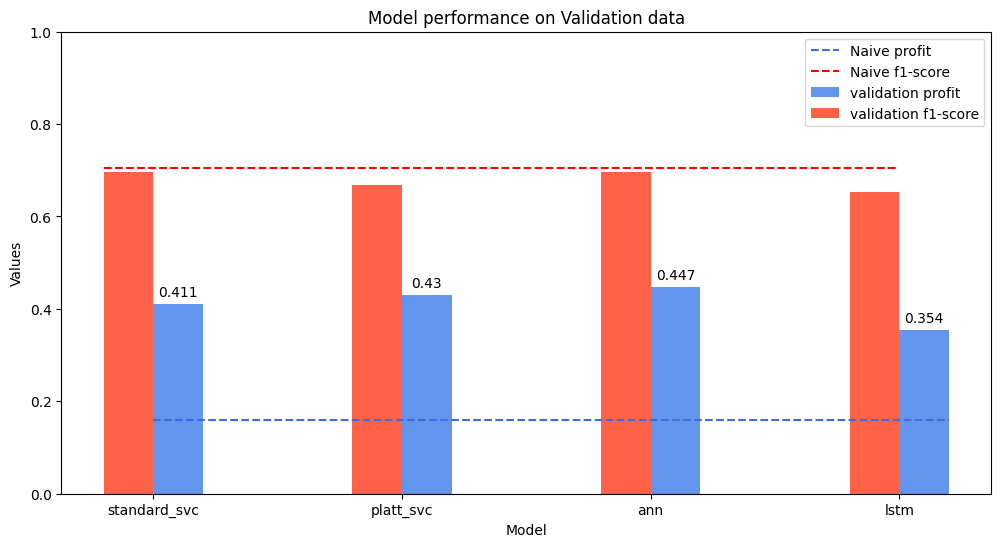

In [168]:
# calculating profit and f1-scores of all models
val_performance_df = pd.DataFrame([[custom_profit_metric(y_val_vF,y_val_pred_standardsvc).numpy(), f1_score(y_val_vF,y_val_pred_standardsvc)],
                                   [custom_profit_metric(y_val_vF,y_val_pred_plattsvc).numpy(), f1_score(y_val_vF,y_val_pred_plattsvc)],
                                   [custom_profit_metric(y_val_vF,y_val_pred_ann).numpy(), f1_score(y_val_vF,y_val_pred_ann)],
                                   [custom_profit_metric(y_val_lstm,y_val_pred_lstm).numpy(), f1_score(y_val_lstm,y_val_pred_lstm)]],
                                  columns = ["validation profit", "validation f1-score"],
                                  index = ["standard_svc", "platt_svc", "ann", "lstm"])

# plotting profit and f1-scores of all models
plt.figure(figsize=(12, 6))
bars_profit = plt.bar(val_performance_df.index, val_performance_df['validation profit'], 
                      color="cornflowerblue", width = 0.2, align="edge", label="validation profit")
plt.bar(val_performance_df.index, val_performance_df['validation f1-score'], 
        color="tomato", width = -0.2, align="edge", label="validation f1-score")
plt.xlabel('Model')
plt.ylabel('Values')
plt.ylim(0,1)
plt.hlines(y = naive_val_profit, xmin = 0, xmax=3.2, color = "royalblue", linestyle="dashed", label="Naive profit")
plt.hlines(y = naive_val_f1, xmin = -0.2, xmax=3, color = "red", linestyle="dashed", label="Naive f1-score")

for bar in bars_profit:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', color='black', fontsize=10)

plt.title('Model performance on Validation data')
plt.legend()

plt.show()

Loooking at profits, all models seem to perform better than the Naive classifier which is good. We will proceed by testing the ANN - which achieved highest profit on the validation data - on the test data.

## 5. Test data performance
### 5.1 Merging train and validation data

In [169]:
# merging train and validation data
X_trainval_vF = pd.concat([X_train_vF, X_val_vF], axis = 0)
y_trainval_vF = pd.concat([y_train_vF, y_val_vF], axis = 0)

### 5.2 Fitting and evaluating final model

In [170]:
# fitting final model
nn_model.fit(x = X_trainval_vF, 
             y = y_trainval_vF, 
             epochs = ann_best_epoch, 
             batch_size = 1, 
             shuffle= False,
             verbose=0)

# calculating scores on test data
ann_test_pred = (nn_model.predict(X_test_vF)>0.5).astype("int").flatten()
ann_test_profit = custom_profit_metric(y_test_vF, ann_test_pred).numpy()

3/3 [==============================] - 0s 521us/step


3/3 [==============================] - 0s 858us/step


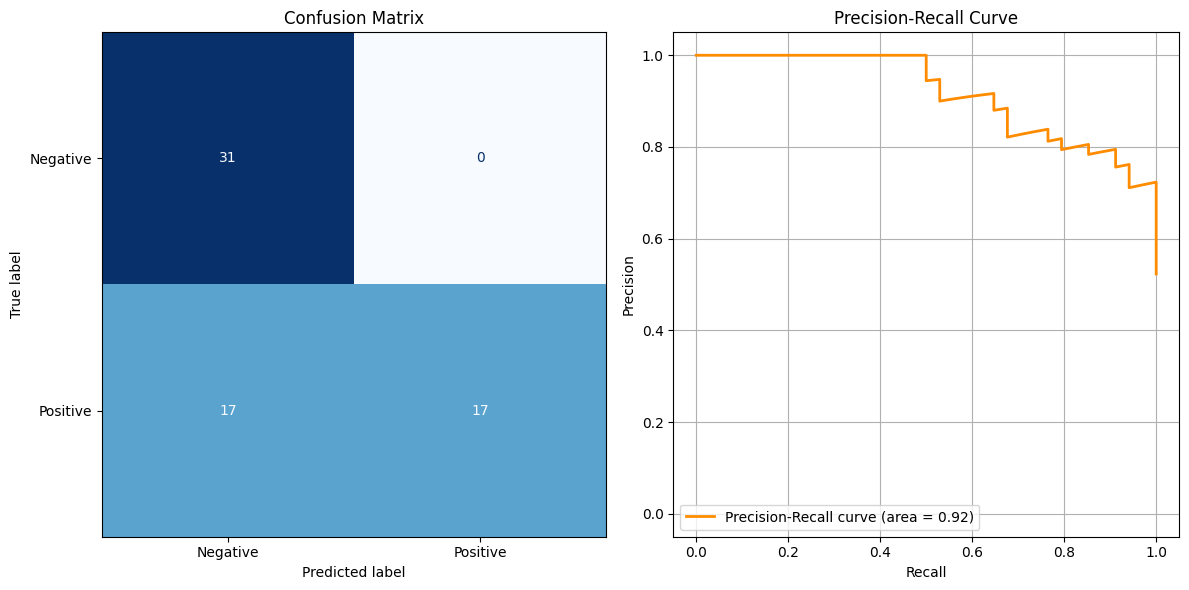

Platt model profit (17-0): 17
Platt model recall 17/(17+17): 0.5
Platt model precision 17/(0+17): 1.0
Platt model accuracy (31+17)/(31+0+17+17): 0.74


In [171]:
# Confusion matrix calc 
y_test_pred_ann = (nn_model.predict(X_test_vF)>0.5).astype("int").flatten()
nn_conf_matrix = confusion_matrix(y_test_vF, y_test_pred_ann)
disp = ConfusionMatrixDisplay(nn_conf_matrix, 
                              display_labels=["Negative", "Positive"])

# AUC calc
precision, recall, thresholds = precision_recall_curve(y_test_vF, 
                                                       nn_model.predict(X_test_vF))
auc_precision_recall = auc(recall, precision)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

disp.plot(cmap="Blues", ax = axs[0], colorbar= False)
axs[0].set_title('Confusion Matrix')

axs[1].plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="best")
axs[1].set_ylim(-0.05, 1.05)
axs[1].grid()

# layout and plot
plt.tight_layout()
plt.show()

# Confusion matrix calculations
print(f"Platt model profit ({nn_conf_matrix[1,1]}-{nn_conf_matrix[0,1]}): {nn_conf_matrix[1,1]-nn_conf_matrix[0,1]}")
print(f"Platt model recall {nn_conf_matrix[1,1]}/({nn_conf_matrix[1,0]}+{nn_conf_matrix[1,1]}): {round(recall_score(y_test_vF, y_test_pred_ann),2)}")
print(f"Platt model precision {nn_conf_matrix[1,1]}/({nn_conf_matrix[0,1]}+{nn_conf_matrix[1,1]}): {round(precision_score(y_test_vF, y_test_pred_ann),2)}")
print(f"Platt model accuracy ({nn_conf_matrix[0,0]}+{nn_conf_matrix[1,1]})/({nn_conf_matrix[0,0]}+{nn_conf_matrix[0,1]}+{nn_conf_matrix[1,0]}+{nn_conf_matrix[1,1]}): {round(accuracy_score(y_test_vF, y_test_pred_ann),2)}")


The performance of the neural network on the test data is fairly good. While it only recommends to trade on about 25% of the total days it has perfect precision. The results make me a bit sceptical though, as the model would not be able to uphold perfect precision over time. The assignment gave us explicit instructions of how much data to allocate to testing. It would however be interesting to investigate if how robust these results are when evaluating on larger test datasets.

## 6. Appendix
### 6.1 - *Figure 1: custom profit metric*

$\frac{TP - FP}{TP + FN}$ = 

= $\frac{TP + TP - (TP + FP)}{TP + FN}$ =

= $\frac{TP + TP}{TP + FN} - \frac{(TP + FP)*TP}{(TP + FN)*TP}$ =

= $\frac{2*TP}{TP + FN} - \frac{(TP^2 + FP*TP)}{(TP^2 + FN*TP)}$ =

= $\frac{2*TP}{TP + FN} * (1 - 0.5*\frac{(TP + FP)}{TP})$ =

= $\frac{2*TP}{TP + FN} * (\frac{\frac{TP}{TP+FP}}{\frac{TP}{TP + FP}} - \frac{0.5}{\frac{TP}{TP + FP}})$ =

= $\frac{TP}{TP + FN} * 2 * \frac{(\frac{TP}{TP+FP} - 0.5)}{\frac{TP}{TP + FP}}$ =

= $\frac{TP}{TP + FN} * \frac{(2*\frac{TP}{TP+FP} - 1)}{\frac{TP}{TP + FP}}$ =

= $\text{recall} \times \frac{(2 \times \text{precision} - 1)}{\text{precision}}$